# Create common dataframe for all the data sets
#### Author: Rimple Sandhu

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline

In [2]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as sp

In [3]:
from ssrs.raster import transform_coordinates, transform_bounds
from ssrs.utils import get_extent_from_bounds
#from telemetry_module import *

In [7]:
data_dir = os.path.join(os.path.abspath(os.path.curdir), 'raw_data')
telemetry_dir = os.path.join(os.path.abspath(os.path.curdir), 'output', 'telemetry')
fig_dir = os.path.join(os.path.abspath(os.path.curdir), 'figs')

In [8]:
%%time
# raw data files from CSG, loaded into pandas
df = {}
wy_small = pd.read_csv(os.path.join(data_dir, 'wy_ge', 'wy_ge_50km_around_totw.txt'), low_memory=False)
wy_big = pd.read_csv(os.path.join(data_dir, 'wy_ge', 'wy_ge_300km_around_totw.txt'), low_memory=False)
pa = pd.read_csv(os.path.join(data_dir, 'pa_ge', 'HuntingdonPA_Data20211210.csv'), low_memory=False)
highres = pd.read_csv(os.path.join(data_dir, 'highres_ge', 'high_res_data-20220324-0414.txt'), low_memory=False)

CPU times: user 31 s, sys: 4.38 s, total: 35.4 s
Wall time: 36.1 s


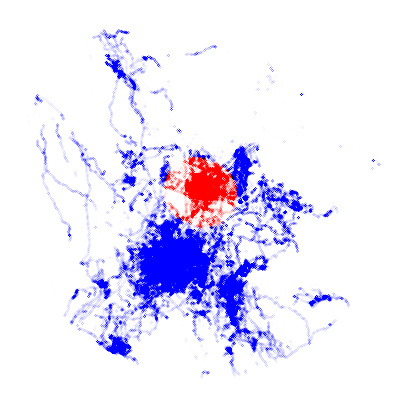

In [9]:
# wy_small and wy_big can be combined togethor
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(wy_small['Longitude'], wy_small['Latitude'], '.r', alpha=0.05, markersize=0.1)
ax.plot(wy_big['Longitude'], wy_big['Latitude'], '.b', alpha=0.05, markersize=0.1)
_ = ax.axis(False)

In [10]:
# combine wy_small and wy_big togethor
wy = pd.concat((wy_small, wy_big), axis=0, ignore_index=True)
df = {
    'wy':wy,
    'pa':pa,
    'hr':highres
}

In [11]:
for key, idf in df.items():
    print(key, list(idf.columns))

wy ['Animal_ID', 'Date_', 'Time_', 'Date_Time', 'LocalTime', 'Date_local', 'Time_Local', 'Month_LocalTime', 'Year_LocalTime', 'JulianDate_LocalTime', 'Latitude', 'Longitude', 'KPH', 'Heading', 'Altitude', 'Season', 'SeasonYr', 'Flighted', 'num_sats', 'Fix', 'VDOP', 'HDOP', 'TimeDiff', 'M_fromLast', 'AltDiff', 'fot', 'lot', 'X', 'Y', 'activity', 'inactivity', 'temperature', 'Age1', 'Age2', 'Sex', 'Date_LocalTime', 'Time_LocalTime', 'FastTrack']
pa ['Animal_ID', 'Date_', 'Time_', 'Date_Time', 'LocalTime', 'Date_LocalTime', 'Time_LocalTime', 'Month_LocalTime', 'Year_LocalTime', 'JulianDate_LocalTime', 'Latitude', 'Longitude', 'KPH', 'Heading', 'Altitude', 'Season', 'SeasonYr', 'num_sats', 'Fix', 'VDOP', 'HDOP', 'X', 'Y', 'activity', 'inactivity', 'temperature', 'Flight', 'Age1', 'Age2', 'Sex', 'TimeDiff', 'M_fromLast', 'AltDiff', 'fot', 'lot']
hr ['OBJECTID', 'Animal_ID', 'Date', 'Time', 'Date_Time', 'GMT_offset', 'LocalTime', 'Month_LocalTime', 'Year_LocalTime', 'JulianDate_LocalTime', '

In [12]:
# memory usage of data
total_memory = 0.
for key, idf in df.items():
    mem_mb = np.around(idf.memory_usage(index=True, deep=True).sum()/1024/1024, 1)
    print(f'{key} = {mem_mb} MB, {idf.shape[0]} rows')
    total_memory += mem_mb
print('Total memory of dataframes = ', total_memory, 'MB')

wy = 3409.5 MB, 3556385 rows
pa = 502.6 MB, 594760 rows
hr = 163.6 MB, 389306 rows
Total memory of dataframes =  4075.7 MB


In [13]:
%%time
# Date_Time is UTC time and LocalTime is local time, and get speed in m/s
for key, idf in df.items():
    idf['TimeUTC'] = pd.to_datetime(idf['Date_Time'], format='%m/%d/%Y %H:%M:%S')
    idf['TimeLocal'] = pd.to_datetime(idf['LocalTime'], format='%m/%d/%Y %H:%M:%S')
    idf['Speed'] = idf['KPH']*5./18. 

CPU times: user 28 s, sys: 49 ms, total: 28.1 s
Wall time: 28.1 s


In [14]:
# drop irrlevant or useles columns to free up memory
for key, idf in df.items():
    idf.drop([
        'Date_', 'Time_', 'Date', 'Time', 'Date_local', 'Date_Time', 'LocalTime', 'Date_Local', 'Time_Local', 
        'Date_LocalTime', 'Time_LocalTime', 'Month_LocalTime', 'Year_LocalTime', 'JulianDate_LocalTime', 
        'activity', 'inactivity','GMT_offset', 'OBJECTID', 'Fix', 'Power', 'FastTrack', 'Age1', 'KPH',
        'temperature', 'num_sats', 'Flight', 'Flighted', 'fot', 'lot', 'Season', 'SeasonYr'
    ], axis=1, inplace=True, errors='ignore')
    idf.sort_index(axis=1, inplace=True)
    print(key,' = ', *idf.columns, '\n')

wy  =  Age2 AltDiff Altitude Animal_ID HDOP Heading Latitude Longitude M_fromLast Sex Speed TimeDiff TimeLocal TimeUTC VDOP X Y 

pa  =  Age2 AltDiff Altitude Animal_ID HDOP Heading Latitude Longitude M_fromLast Sex Speed TimeDiff TimeLocal TimeUTC VDOP X Y 

hr  =  AltDiff Altitude Animal_ID HDOP Heading Latitude Longitude M_fromLast Speed TimeDiff TimeLocal TimeUTC VDOP 



In [15]:
# rename columns to ensure consistency
for key, idf in df.items():
    idf.rename(columns = {
        'Animal_ID': 'AnimalID', 'Age2':'Age', 'M_fromLast':'DistDiff', 
    }, inplace = True, errors='ignore')

In [16]:
# add missing columns in high res data 
idf = df['hr']
latlon = idf[['Latitude','Longitude']].values
xloc, yloc = transform_coordinates('EPSG:4326', 'ESRI:102008', latlon[:,1], latlon[:,0])
idf['X'] = xloc
idf['Y'] = yloc
idf['Age'] = 'U'
idf['Sex'] = 'U'

In [17]:
# reduce memory usage further for saving
total_memory = 0.
for key, idf in df.items():
    #idf['Sex'] = idf['Sex'].astype('|S') 
    #idf['Age'] = idf['Age'].astype('|S')
    float64_cols = list(idf.select_dtypes(include='float64'))
    float64_cols.remove('X')
    float64_cols.remove('Y')
    float64_cols.remove('Latitude')
    float64_cols.remove('Longitude')
    idf[float64_cols] = idf[float64_cols].astype('float32')
    int64_cols = list(idf.select_dtypes(include='int64'))
    idf[int64_cols] = idf[int64_cols].astype('int32')
    mem_mb = np.around(idf.memory_usage(index=True, deep=True).sum()/1024/1024, 1)
    total_memory += mem_mb
    print(key, ' = ', mem_mb, 'MB')
print('Total memory usage = ', total_memory, 'MB')

wy  =  678.3 MB
pa  =  113.4 MB
hr  =  74.3 MB
Total memory usage =  865.9999999999999 MB


In [18]:
# check if columns in each dataset are same
for key, idf in df.items():
    idf.sort_index(axis=1, inplace=True)
    print(key,' = ', *idf.columns, '\n')

wy  =  Age AltDiff Altitude AnimalID DistDiff HDOP Heading Latitude Longitude Sex Speed TimeDiff TimeLocal TimeUTC VDOP X Y 

pa  =  Age AltDiff Altitude AnimalID DistDiff HDOP Heading Latitude Longitude Sex Speed TimeDiff TimeLocal TimeUTC VDOP X Y 

hr  =  Age AltDiff Altitude AnimalID DistDiff HDOP Heading Latitude Longitude Sex Speed TimeDiff TimeLocal TimeUTC VDOP X Y 



In [19]:
# sort them accoding to animal id and time
for key, idf in df.items():
    idf.set_index(['AnimalID', 'TimeLocal'], inplace=True, drop=False)
    idf.sort_index(inplace=True)
    idf.reset_index(inplace=True, drop=True)

In [20]:
# check if timediff, altdiff, distdiff provided by CSG check out, amnswer:NO
# For pa and wy_small it seems fine but not for other datasets
# there seems to data missing from whcih timediff is computed in wy_big and highres
# lot of mismatch at cm scale between CSG distdiff and computed here
# for instance, change the rtol below and see number of mismatches change
# add bool column showing the first data of the day
print('# of rows with mismatched diff pars:')
for key, idf in df.items():
    idf['FirstOfDay'] = (idf.TimeLocal.dt.date.diff().dt.total_seconds() != 0) | (idf.AnimalID.diff() != 0)
    timediff = idf['TimeLocal'].diff().dt.total_seconds().bfill().round(5)
    altdiff = idf['Altitude'].diff().bfill()
    xdiff = idf['X'].diff().bfill()
    ydiff = idf['Y'].diff().bfill()
    distdiff = np.sqrt(xdiff**2 + ydiff**2)
    not_first = ~idf['FirstOfDay']
    print('TimeDiff: ', key, ' = ', (~np.isclose(timediff[not_first], idf['TimeDiff'][not_first], rtol=1e-2)).sum())
    print('AltDiff: ', key, ' = ', (~np.isclose(altdiff[not_first], idf['AltDiff'][not_first], rtol=1e-2)).sum())
    print('DistDiff: ', key, ' = ', (~np.isclose(distdiff[not_first], idf['DistDiff'][not_first], rtol=1e-1)).sum())

# of rows with mismatched diff pars:
TimeDiff:  wy  =  258
AltDiff:  wy  =  258
DistDiff:  wy  =  245
TimeDiff:  pa  =  0
AltDiff:  pa  =  0
DistDiff:  pa  =  0
TimeDiff:  hr  =  89
AltDiff:  hr  =  68
DistDiff:  hr  =  80


In [21]:
# recmoputing the diff parameters, the ones from csg not good, see above block
for key, idf in df.items():
    idf['TimeDiff'] = idf['TimeLocal'].diff().dt.total_seconds().bfill().round(5).astype('float32')
    idf['AltDiff'] = idf['Altitude'].diff().bfill().astype('float32')
    xdiff = idf['X'].diff().bfill()
    ydiff = idf['Y'].diff().bfill()
    idf['DistDiff'] = np.sqrt(xdiff**2 + ydiff**2).astype('float32')
    #idf.iloc[22000:22020]

In [22]:
# check if X and Y provided by CSG are in the same projection system, Answer: NO
for key, idf in df.items():
    idfshort = idf.iloc[1:5]
    xlocs, ylocs = transform_coordinates('EPSG:4326', 'ESRI:102008', 
                                         idfshort['Longitude'].values, idfshort['Latitude'].values)
    print(key, '\n', xlocs, '\n', idfshort['X'].values)

wy 
 [-765947.37678226 -765946.29851942 -765954.67298189 -765950.81986526] 
 [-765947.37678226 -765946.29851942 -765954.67298189 -765950.81986526]
pa 
 [1311843.08679903 1311845.80120861 1311836.62786618 1311835.12792149] 
 [1308974.04790199 1308976.62536932 1308967.8336613  1308965.96897215]
hr 
 [-595995.7782866  -595995.73968605 -595996.27685914 -595997.35993084] 
 [-595995.7782866  -595995.73968605 -595996.27685914 -595997.35993084]


In [23]:
# recompute X and Y in the projected coordinate system, ignore the ones provided by CSG
for key, idf in df.items():
    latlon = idf[['Latitude','Longitude']].values
    xloc, yloc = transform_coordinates('EPSG:4326', 'ESRI:102008', latlon[:,1], latlon[:,0])
    idf['X'] = xloc
    idf['Y'] = yloc

In [24]:
# check if any nans in the data
# only remaining is VDOP for pa datasets, i think for older units no vdop is available
for key, idf in df.items():
    for icol in idf.columns:
        num_nans = idf[icol].isna().sum()
        if num_nans > 0:
            print(key, icol, ' : ', num_nans)
# use HDOP to assign Vdop values, comment out lines below if you dont like this
inds = df['pa']['VDOP'].isna()
df['pa'].loc[inds, 'VDOP'] = df['pa'].loc[inds, 'HDOP']

pa VDOP  :  232424


In [25]:
# memory usage of data
total_memory = 0.
for key, idf in df.items():
    mem_mb = np.around(idf.memory_usage(index=True, deep=True).sum()/1024/1024, 1)
    print(f'{key} = {mem_mb} MB, {idf.shape[0]} rows')
    total_memory += mem_mb
print('Total memory of dataframes = ', total_memory, 'MB')

wy = 681.7 MB, 3556385 rows
pa = 114.0 MB, 594760 rows
hr = 74.6 MB, 389306 rows
Total memory of dataframes =  870.3000000000001 MB


In [26]:
# print out time range of data, and number of unique GE's
for key, idf in df.items():
    print(key, idf['TimeLocal'].dt.date.min(), idf['TimeLocal'].dt.date.max(), idf['AnimalID'].nunique())

wy 2019-03-31 2020-05-31 38
pa 2009-02-20 2020-12-31 75
hr 2022-03-24 2022-04-13 5


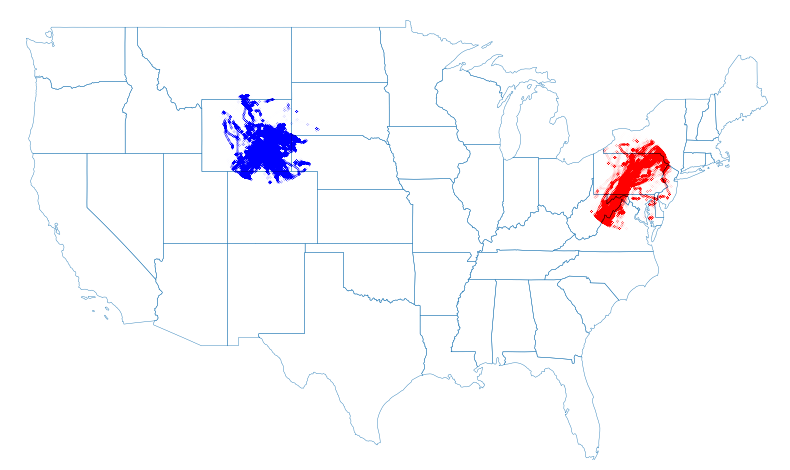

In [27]:
newdf = {key: val for key, val in df.items() if key !='hr'}
# plot data on the map of usa in lat lon
#usa = Image.open(os.path.join(data_dir, 'maps', 'usa_50m', 'NE2_50M_SR_W.tif'))
lstyles = ['.b', '.r', '.k', '.g']
usa = gpd.read_file(os.path.join(data_dir, 'maps', 'usa_states', 'cb_2018_us_state_20m.shp'))
fig, ax = plt.subplots(figsize=(8,8))
#usa.plot(ax=ax, column='GEOID', legend=False, cmap='OrRd', facecolor="none", edgecolor="black")
usa.boundary.plot(ax=ax, linewidth=0.3)
for i, (ikey, idf) in enumerate(newdf.items()):
    ax.plot(idf['Longitude'], idf['Latitude'], lstyles[i], alpha=0.05, markersize=0.1, label=ikey)
ax.set_xlim([-126, -66])
ax.set_ylim([25, 50])
#lg = ax.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0., markerscale=60)
# for lh in lg.legendHandles: 
#     lh.set_alpha(1)
_ = ax.axis(False)
fig.tight_layout()
fig.savefig(os.path.join(fig_dir,f'telemetry_data.png'), dpi=200)

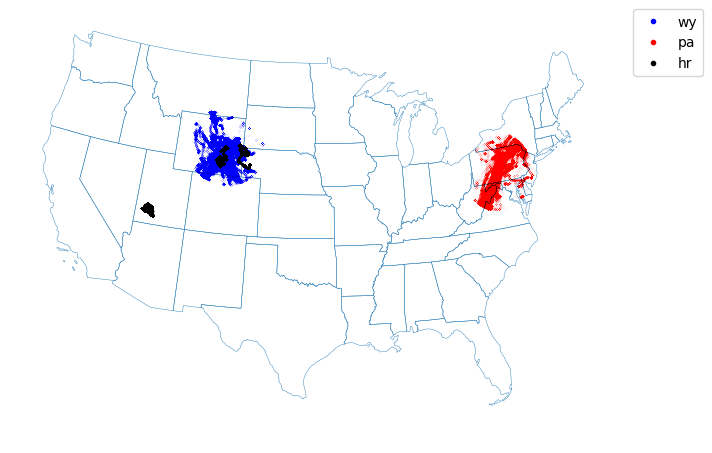

In [28]:
# plot in projected coordinate ref system
usa_crs = usa.to_crs(crs='ESRI:102008')
fig, ax = plt.subplots(figsize=(8,8))
usa_crs.boundary.plot(ax=ax, linewidth=0.3)
for i, (ikey, idf) in enumerate(df.items()):
    ax.plot(idf['X'], idf['Y'], lstyles[i], alpha=0.05, markersize=0.1, label=ikey)
ax.set_xlim([-2.5e6, 2.5e6])
ax.set_ylim([-2e6, 1.5e6])
#ax.grid(True)
lg = ax.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0., markerscale=60)
for lh in lg.legendHandles: 
    lh.set_alpha(1)
_ = ax.axis(False)

In [29]:
# combine all groups to form one dataframe
list_of_dfs = []
for key, idf in df.items():
    idf['Group'] = key
    list_of_dfs.append(idf)
odf = pd.concat(list_of_dfs, axis=0)
odf['Sex'] = odf['Sex'].astype('category')
odf['Age'] = odf['Age'].astype('category')
odf['Group'] = odf['Group'].astype('category')
#print_memory_usage(odf)
#print_summary_by_column(odf)
odf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4540451 entries, 0 to 389305
Data columns (total 19 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Age         category      
 1   AltDiff     float32       
 2   Altitude    float32       
 3   AnimalID    int32         
 4   DistDiff    float32       
 5   HDOP        float32       
 6   Heading     float32       
 7   Latitude    float64       
 8   Longitude   float64       
 9   Sex         category      
 10  Speed       float32       
 11  TimeDiff    float32       
 12  TimeLocal   datetime64[ns]
 13  TimeUTC     datetime64[ns]
 14  VDOP        float32       
 15  X           float64       
 16  Y           float64       
 17  FirstOfDay  bool          
 18  Group       category      
dtypes: bool(1), category(3), datetime64[ns](2), float32(8), float64(4), int32(1)
memory usage: 415.7 MB


In [30]:
odf.rename(columns = {'Speed':'VelocityHor_TU', 'Heading': 'HeadingHor_TU'}, errors='ignore', inplace=True)
odf.rename(columns = {'X':'PositionX', 'Y': 'PositionY'}, errors='ignore', inplace=True)
odf.rename(columns = {'HDOP':'ErrorHDOP', 'VDOP': 'ErrorVDOP'}, errors='ignore', inplace=True)
odf['VelocityHor'] = odf['DistDiff']/odf['TimeDiff']
odf['VelocityVer'] = odf['AltDiff']/odf['TimeDiff']
xdiff = odf['PositionX'].diff().bfill()
ydiff = odf['PositionY'].diff().bfill()
odf['HeadingHor'] = (np.degrees(np.arctan2(xdiff, ydiff))) % 360
odf['HeadingHor'] = odf['HeadingHor'].astype('float32')
odf['VelocityX'] = odf['VelocityHor'] * np.sin(np.radians(odf['HeadingHor']))
odf['VelocityY'] = odf['VelocityHor'] * np.cos(np.radians(odf['HeadingHor']))
odf['VelocityX_TU'] = odf['VelocityHor_TU'] * np.sin(np.radians(odf['HeadingHor_TU']))
odf['VelocityY_TU'] = odf['VelocityHor_TU'] * np.cos(np.radians(odf['HeadingHor_TU']))
odf.sort_index(axis=1, inplace=True)
#sort_according_to_columns(odf, ['Group', 'AnimalID', 'TimeLocal'])
#print_memory_usage(odf)
#print_summary_by_column(odf)

In [34]:
%time
#odf.to_pickle(os.path.join(telemetry_dir, f'ge_dataframe.pickle_base'))
#odf.to_pickle(os.path.join(telemetry_dir, f'ge_dataframe.pickle'))
#odf.to_parquet(os.path.join(telemetry_dir, f'ge_dataframe.parquet_base'))
odf.to_pickle(os.path.join(telemetry_dir, f'csg_ge_vr.pkl'))
odf.to_parquet(os.path.join(telemetry_dir, f'csg_ge_vr.prq'))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.3 µs


In [32]:
odf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4540451 entries, 0 to 389305
Data columns (total 26 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Age             category      
 1   AltDiff         float32       
 2   Altitude        float32       
 3   AnimalID        int32         
 4   DistDiff        float32       
 5   ErrorHDOP       float32       
 6   ErrorVDOP       float32       
 7   FirstOfDay      bool          
 8   Group           category      
 9   HeadingHor      float32       
 10  HeadingHor_TU   float32       
 11  Latitude        float64       
 12  Longitude       float64       
 13  PositionX       float64       
 14  PositionY       float64       
 15  Sex             category      
 16  TimeDiff        float32       
 17  TimeLocal       datetime64[ns]
 18  TimeUTC         datetime64[ns]
 19  VelocityHor     float32       
 20  VelocityHor_TU  float32       
 21  VelocityVer     float32       
 22  VelocityX       flo

In [ ]:
def highlight_max(x, color):
    return np.where(x == np.nanmax(x.to_numpy()), f"color: {color};", None)
ixdf = np.around(df['wy'].TimeDiff.value_counts().sort_values(ascending=False)*100./df['wy'].shape[0], 1)
ixdf = ixdf.sort_index()
ixdf = ixdf[ixdf.index>0].cumsum()
#ixdf.to_frame().style.apply(highlight_max, axis=1)

In [ ]:
ixdf[:30]